<a href="https://colab.research.google.com/github/StasGT/DL/blob/main/Facenet512%2BMTCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### facenet-pytorch LFW evaluation

In [ ]:
# Facenet512 Installation
!pip install facenet_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.6/755.6 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 75.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 80.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 43.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2

In [ ]:
from facenet_pytorch import MTCNN, InceptionResnetV1, fixed_image_standardization, training, extract_face
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler, SequentialSampler
from torchvision import datasets, transforms
import numpy as np
import os

In [ ]:
# Connection to the Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Make folders, downloading the LFW dataset, unzip it & folders definition
%cd '/content/drive/MyDrive/'
%mkdir -p '/dl_for_cv/data/'
%cd '/content/drive/MyDrive/dl_for_cv/data/'

!wget http://100byte.ru/python/data/lfw_deepfunneled.tgz
!tar -xzf lfw_deepfunneled.tgz

data_dir = '/content/drive/MyDrive/dl_for_cv/data/lfw-deepfunneled/'
%cd '/content/drive/MyDrive/dl_for_cv/data/lfw-deepfunneled/'

/content/drive/MyDrive
/content/drive/MyDrive/dl_for_cv/data
--2025-05-13 19:09:31--  http://100byte.ru/python/data/lfw_deepfunneled.tgz
Resolving 100byte.ru (100byte.ru)... 91.189.114.23
Connecting to 100byte.ru (100byte.ru)|91.189.114.23|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 108761145 (104M) [application/octet-stream]
Saving to: ‘lfw_deepfunneled.tgz.1’

lfw_deepfunneled.tg 100%[===================>] 103.72M  25.2MB/s    in 6.9s    

2025-05-13 19:09:39 (15.0 MB/s) - ‘lfw_deepfunneled.tgz.1’ saved [108761145/108761145]

/content/drive/MyDrive/dl_for_cv/data/lfw-deepfunneled


In [ ]:
# Define batch size, number of workers & computation device
batch_size = 1
workers = 1
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cpu


In [ ]:
# Attributes definition of the MTCNN (Multi-task Cascaded Convolutional Network)
mtcnn = MTCNN(
    image_size=160,
    margin=14,
    device=device,
    selection_method='center_weighted_size'
)

In [ ]:
# Define the data loader for the input set of images
data_dir = '/content/drive/MyDrive/dl_for_cv/data/lfw-deepfunneled/'
orig_img_ds = datasets.ImageFolder(data_dir, transform=None)

In [ ]:
# Overwrites class labels in dataset with path so path can be used for saving output in mtcnn batches
orig_img_ds.samples = [
    (p, p)
    for p, _ in orig_img_ds.samples
]

loader = DataLoader(
    orig_img_ds,
    num_workers=workers,
    batch_size=batch_size,
    collate_fn=training.collate_pil
)


In [ ]:
# Passing the data to the MTCNN for cropping and alignment
data_dir_crop = '/content/drive/MyDrive/dl_for_cv/data/_cropped/'
crop_paths = []
box_probs = []

for i, (x, b_paths) in enumerate(loader):
    crops = [p.replace(data_dir, data_dir_crop) for p in b_paths]
    mtcnn(x, save_path=crops)
    crop_paths.extend(crops)
    print('\rBatch {} of {}'.format(i + 1, len(loader)), end='')

Batch 13233 of 13233

In [ ]:
# Remove mtcnn to reduce GPU memory usage
del mtcnn
torch.cuda.empty_cache()

In [ ]:
# create dataset and data loaders from cropped images output from MTCNN

trans = transforms.Compose([
    np.float32,
    transforms.ToTensor(),
    fixed_image_standardization
])

dataset = datasets.ImageFolder(data_dir_crop, transform=trans)

embed_loader = DataLoader(
    dataset,
    num_workers=workers,
    batch_size=batch_size,
    sampler=SequentialSampler(dataset)
)

In [ ]:
# Load pretrained resnet model, pass the data through the network & obtain embeddings
resnet = InceptionResnetV1(classify=False, pretrained='vggface2').to(device)

classes = []
embeddings = []
resnet.eval()
with torch.no_grad():
    for xb, yb in embed_loader:
        xb = xb.to(device)
        b_embeddings = resnet(xb)
        b_embeddings = b_embeddings.to('cpu').numpy()
        classes.extend(yb.numpy())
        embeddings.extend(b_embeddings)

In [ ]:
# Save embeddings, class names, paths to cropped & aligned images
# Embeddings are 512-dimensional vectors that describe each face
import pandas as pd
embeddings_dict = dict(zip(crop_paths, embeddings))

df = pd.DataFrame(embeddings, index=classes)
df.index.name = 'Classes'
df.to_csv('/content/drive/MyDrive/dl_for_cv/data/embeddings.csv')

#print(len(embeddings_dict), embeddings_dict.keys())
e_dict = pd.DataFrame.from_dict(embeddings_dict, orient='index')
e_dict.to_csv('/content/drive/MyDrive/dl_for_cv/data/embeddings_dict.csv')

13232

In [ ]:
# Now we can download it from Google Drive at another time
import pandas as pd
e_dict = pd.read_csv('/content/drive/MyDrive/dl_for_cv/data/embeddings_dict.csv')

dfn = pd.read_csv('/content/drive/MyDrive/dl_for_cv/data/embeddings.csv')
embeddings_cast = dfn.values.tolist()

#dfn.iloc[-10:-1, :10]
#dfn[dfn['Classes']==500]

accuracy: 0.999636


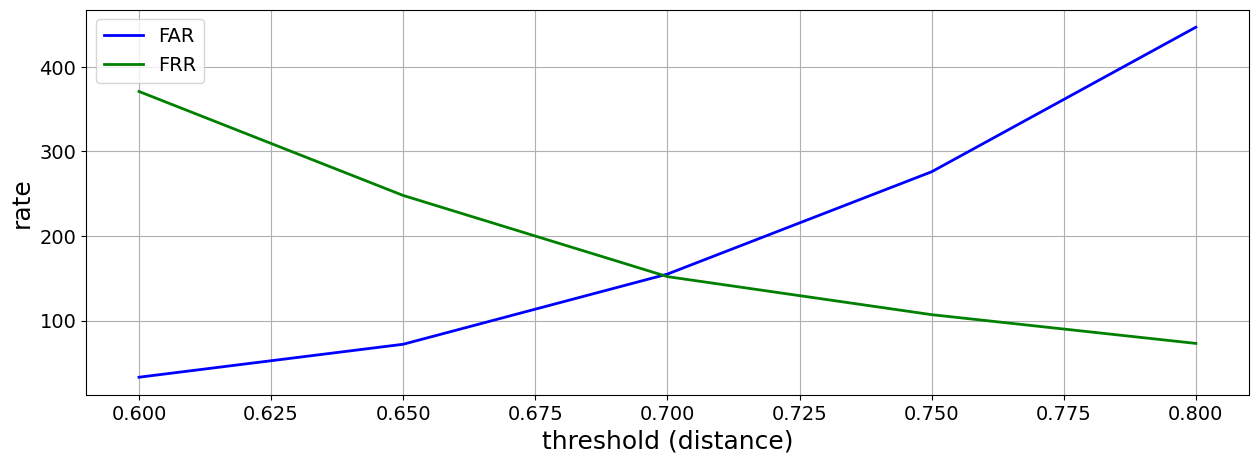

In [ ]:
# Evaluation and tuning
import matplotlib.pyplot as plt
import random
list2 = dfn.values.tolist()

thrs = np.linspace(0.6, 0.8, 5)
fars, frrs = [], []



def cosine(a, b):
  dot = np.sum(np.multiply(a, b), axis=0)
  norm = np.linalg.norm(a, axis=0) * np.linalg.norm(b, axis=0)
  similarity = dot / norm
  dist = np.arccos(similarity) / np.pi
  return dist

def linear(a, b):
  diff = np.subtract(a, b)
  dist = np.sum(np.square(diff),0)
  return dist


def threshold(loops):
  for thr in thrs:
    far, frr = 0, 0
    for i in range(loops):
      a = random.randrange(0, 13230)
      b = random.randrange(0, 13230)
      dist = linear(list2[a][1:], list2[b][1:])
      if (dist < thr) & (list2[a][0] != list2[b][0]): far += 1
      if (dist > thr) & (list2[a][0] == list2[b][0]): frr += 1

    fars.append(far)
    frrs.append(frr)

  plt.figure(figsize=(15, 5))
  plt.plot(thrs, fars, 'b', label='FAR', linewidth=2.0)
  plt.plot(thrs, frrs, 'g', label='FRR', linewidth=2.0)
  plt.grid(True)
  plt.xlabel('threshold (distance)', fontsize=18)
  plt.ylabel('rate', fontsize=18)
  plt.legend(fontsize=14)
  plt.tick_params(labelsize=14)


def evaluation(loops):
  tp, fp, fn, tn = 0, 0, 0, 0
  thr = 0.6
  for i in range(loops):
    a = random.randrange(0, 13230)
    b = random.randrange(0, 13230)
    dist = linear(list2[a][1:], list2[b][1:])
    if (dist < thr):
      if ((list2[a][0] == list2[b][0])): tp+=1
      else: fp+=1
    if (dist > thr):
      if ((list2[a][0] == list2[b][0])): fn+=1
      else: tn+=1
  print("Accuracy:", (tp + tn) / (tp + tn + fn + fp))

threshold(1000000)
evaluation(1000000)

In [ ]:
# Google Colab's magic recipe for capturing webcam shot

from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='/content/sample_data/test/10000/1.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
# Make a shot.
%mkdir -p '/content/sample_data/test/10000'

from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [ ]:

data_dir_crop = '/content/sample_data/_cropped/'
crop_paths = []
box_probs = []

%cd /content/
%mkdir /content/sample_data/test

%cd /content/sample_data/test
!ls -a
!rm -r '.ipynb_checkpoints'
!ls -a


data_dir = '/content/sample_data/test'
orig_img_ds = datasets.ImageFolder(data_dir, transform=None)

orig_img_ds.samples = [(p, p) for p, _ in orig_img_ds.samples]
loader = DataLoader(orig_img_ds, num_workers=workers, batch_size=batch_size, collate_fn=training.collate_pil)

data_dir_crop = '/content/sample_data/_cropped/'
crop_paths = []
box_probs = []

for i, (x, b_paths) in enumerate(loader):
    crops = [p.replace(data_dir, data_dir_crop) for p in b_paths]
    mtcnn(x, save_path=crops)
    crop_paths.extend(crops)
    print('\rBatch {} of {}'.format(i + 1, len(loader)), end='')

    y = x[0]
    print(type(y))
    npi = np.array(y)
    print(npi.mean(), npi.std(), npi.shape)



/content
mkdir: cannot create directory ‘/content/sample_data/test’: File exists
/content/sample_data/test
.  ..  10000
rm: cannot remove '.ipynb_checkpoints': No such file or directory
.  ..  10000
Batch 1 of 1<class 'PIL.Image.Image'>
147.2497905815972 58.99923453794054 (480, 640, 3)


In [ ]:

trans = transforms.Compose([
    np.float32,
    transforms.ToTensor(),
    fixed_image_standardization
])

dataset = datasets.ImageFolder(data_dir_crop, transform=trans)

embed_loader = DataLoader(
    dataset,
    num_workers=workers,
    batch_size=batch_size,
    sampler=SequentialSampler(dataset)
)


resnet = InceptionResnetV1(classify=False, pretrained='vggface2').to(device)

classes = []
embeddings = []
resnet.eval()
with torch.no_grad():
    for xb, yb in embed_loader:
        xb = xb.to(device)
        b_embeddings = resnet(xb)
        b_embeddings = b_embeddings.to('cpu').numpy()
        classes.extend(yb.numpy())
        embeddings.extend(b_embeddings)

In [ ]:
def linear(a, b):
  diff = np.subtract(a, b)
  dist = np.sum(np.square(diff),0)
  return dist

fp = 0
it_s = 0
thr = 0.95 # Make the threshold higher for more fun

print("Original:")
display(Image('/content/sample_data/_cropped/10000/1.jpg'))
print("Threshold =", thr)
print("=======================================================")

for i in np.array(embeddings_cast):

  dist = linear(i[1:], embeddings[0])

  if (dist < thr):
    fp +=1
    display(Image(e_dict.iloc[it_s, 0]))
    print(dist, e_dict.iloc[it_s, 0])
  it_s +=1
print("Summ of fp:", fp)


In [ ]:
from PIL import Image as im
mtcnn = MTCNN(keep_all=True, device=device)
iam = im.open('/content/sample_data/test/10000/1.jpg')

box, prob = mtcnn.detect(iam)



resnet = InceptionResnetV1(classify=False, pretrained='vggface2').to(device)

resnet.eval()
with torch.no_grad():
  xb = mtcnn(iam).to(device)
  emb = resnet(xb)
  emb = emb.to('cpu').numpy()



x = box[0, 0]
y = box[0, 1]
w = box[0, 2] - x
h = box[0, 3] - y
x1 = box[0, 2]
y1 = box[0, 3]

crop = iam.crop((x, y, x1, y1))
display(iam)
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

imgplot = plt.imshow(iam)
#rect = Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
#plt.gca().add_patch(rect)
plt.plot([x, x1, x1, x, x], [y, y, y1, y1, y], color='red', linewidth=2)
plt.text(x, y-10, str("%.5f" % prob[0]), color='red')
plt.show()

In [ ]:
def linear(a, b):
  diff = np.subtract(a, b)
  dist = np.sum(np.square(diff),0)
  return dist

fp = 0
it_s = 0
thr = 0.95 # Make the threshold higher for more fun

print("Original:")
display(Image('/content/sample_data/_cropped/10000/1.jpg'))
print("Threshold =", thr)
print("=======================================================")

for i in np.array(embeddings_cast):

  dist = linear(i[1:], emb[0])

  if (dist < thr):
    fp +=1
    display(Image(e_dict.iloc[it_s, 0]))
    print(dist, e_dict.iloc[it_s, 0])
  it_s +=1
print("Summ of fp:", fp)